### RNN ile Uçak yolcusu sayısı tahmini

#### 1) İş problemi

*   **Month:** Aylıkolarak yer alan tarih değişekni.

*   **Passengers:** İlgili işelm tarihindeki yolcu sayısının, yani aylık yolcu sayısının temsil etmektedir.

#### 1.1) Gerekli Kütüphaneler




In [1]:
!pip install optuna

In [2]:
!pip install catboost

In [3]:
!pip install lightgbm

In [4]:
!pip install pmdarima

In [5]:

import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt

import pmdarima as pm

from tabulate import tabulate


from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')


import os
os.environ['TF_CCP_MIN_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from google.colab import drive

In [6]:
plt.style.use('fivethirtyeight')

#### 2) Veriyi Anlamak
#### 2.1)Veri setinin Yüklenmesi ve İncelenmesi

In [7]:
drive.mount('/gdrive')
%cd /gdrive
os.chdir('/gdrive/My Drive/TGY_YSA')

!ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
 101.ipynb   104.ipynb		       international-airline-passengers.csv   tsla.csv
 102.ipynb   catboost_info	       mymodel.5h			      Untitled0.ipynb
 103.ipynb  'Garbage classification'   mymodel.h5


In [8]:
df=pd.read_csv('international-airline-passengers.csv')

In [9]:
df.columns=['Month','Passengers']

In [10]:
df=df.iloc[:-1,:]

In [11]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [12]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [13]:
df.shape

(144, 2)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [16]:
df.Month=pd.to_datetime(df.Month)

In [17]:
df.dtypes

Month         datetime64[ns]
Passengers           float64
dtype: object

In [18]:
print('',df.Month.min(),'\n',df.Month.max())

 1949-01-01 00:00:00 
 1960-12-01 00:00:00


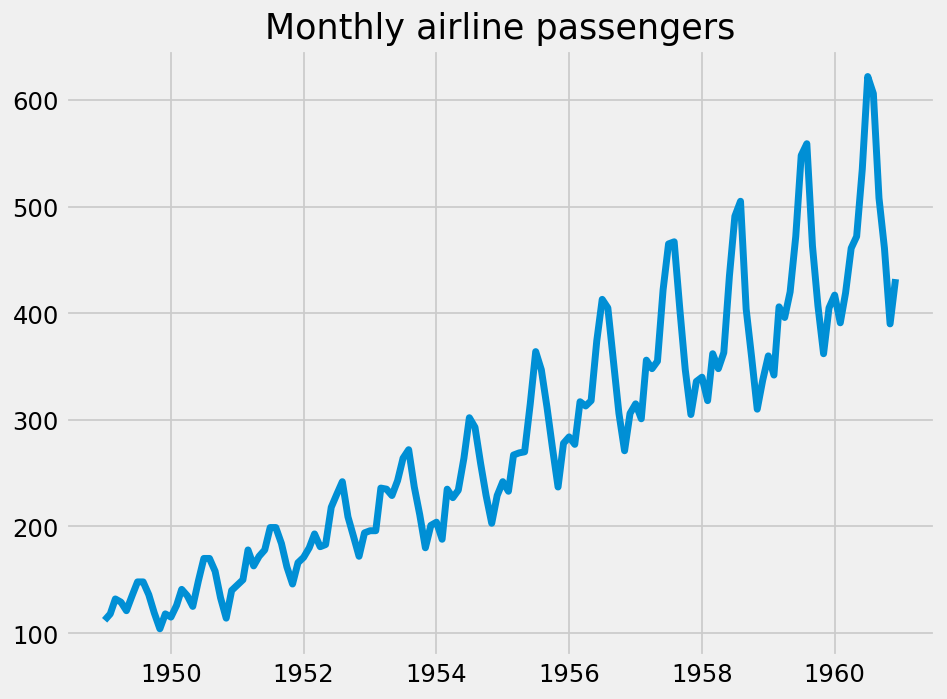

In [19]:
plt.figure(figsize=(8,6),dpi=125)
plt.plot(df.Month,df.Passengers)
plt.title('Monthly airline passengers')
plt.show()

In [20]:
dfv=df.copy()

In [21]:
dfv=df.copy()

In [22]:
dfv=dfv.set_index('Month')

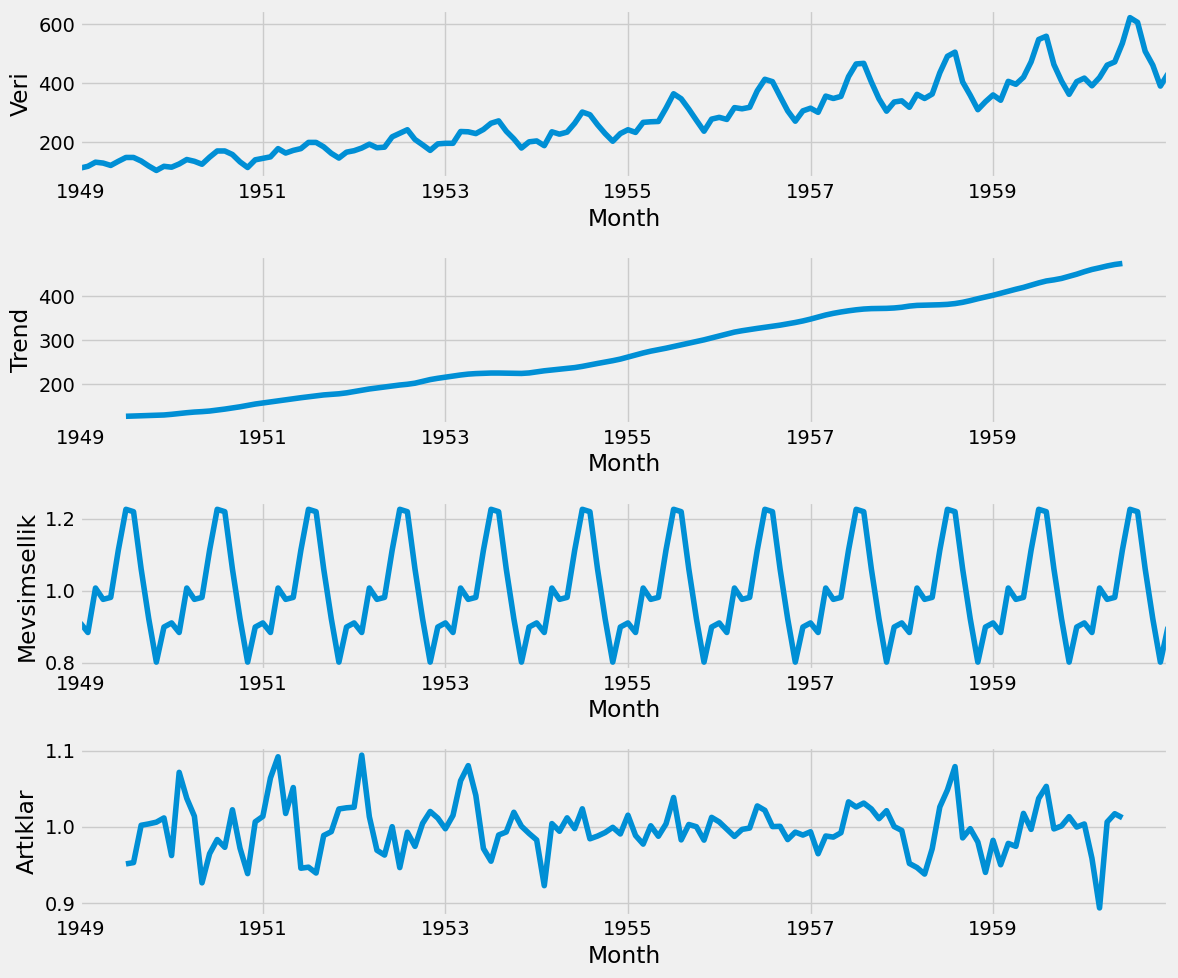

In [52]:
decomposition=sm.tsa.seasonal_decompose(dfv['Passengers'],model='multiplicative')

fig,ax=plt.subplots(4,1,figsize=(12,10))


dfv['Passengers'].plot(ax=ax[0])
ax[0].set_ylabel('Veri')

decomposition.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax[2])
ax[2].set_ylabel('Mevsimsellik')

decomposition.resid.plot(ax=ax[3])
ax[3].set_ylabel('Artıklar')


plt.tight_layout()
plt.show()

In [24]:
dfv['Month']=dfv.index.month
dfv['Quarter']=dfv.index.quarter
dfv['Year']=dfv.index.year

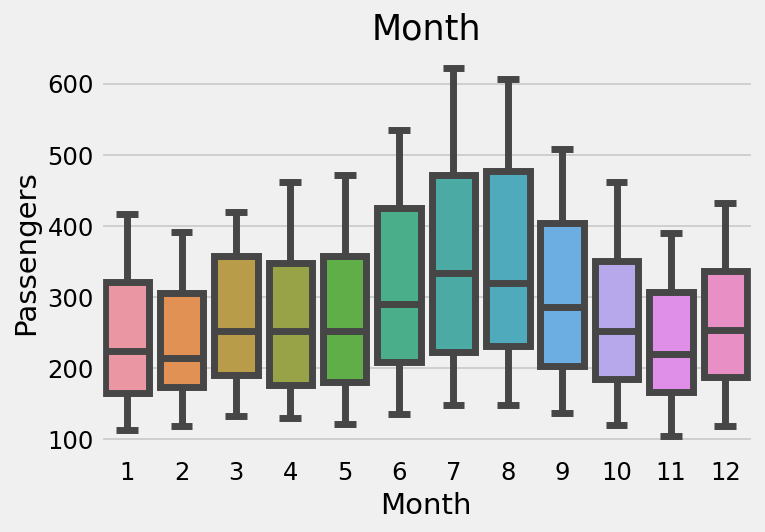

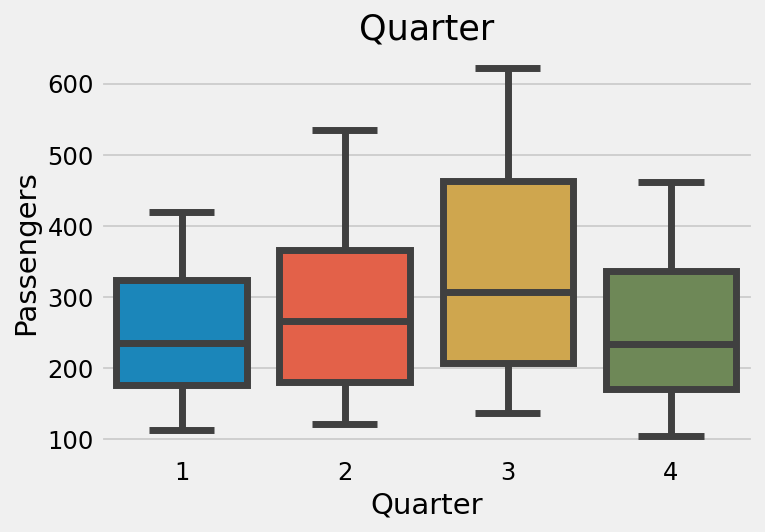

In [25]:
for i in dfv.columns[1:-1]:
  plt.figure(figsize=(6,4),dpi=125)
  plt.title(i)
  sns.boxplot(data=dfv,y=dfv.Passengers,x=i)
  plt.show()

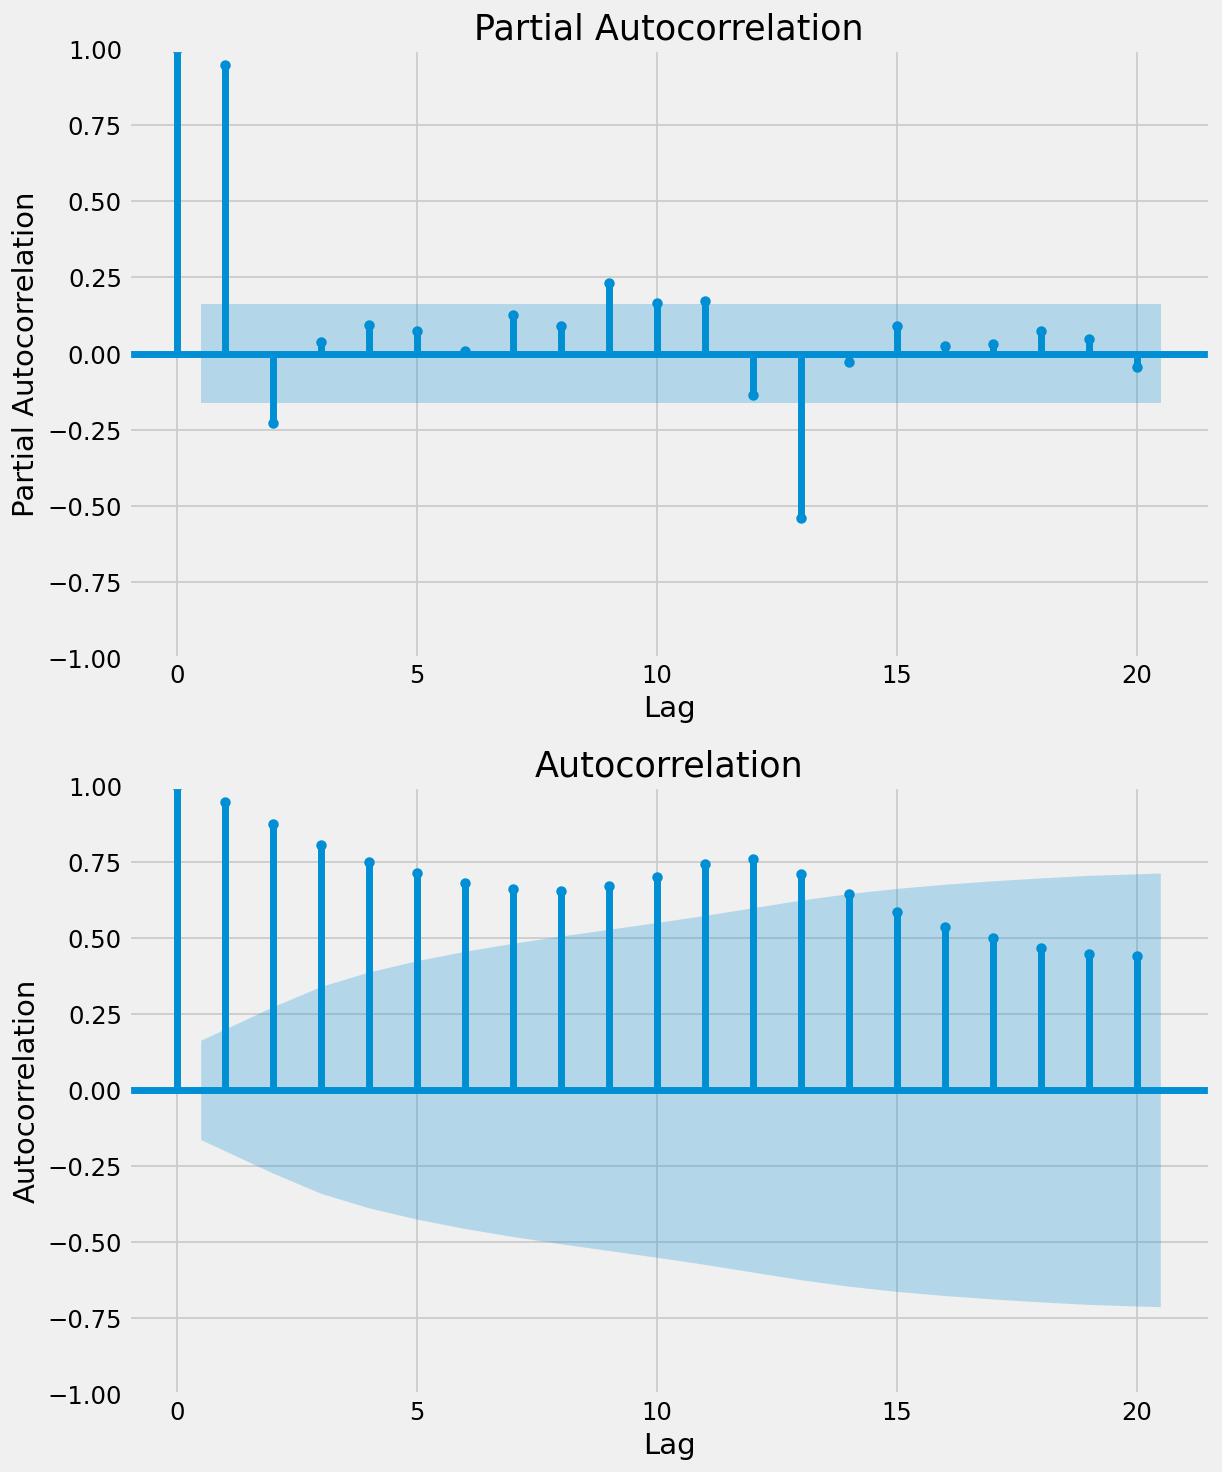

In [26]:
fig, ax=plt.subplots(2,1,figsize=(10,12),dpi=125)
plot_pacf(dfv.Passengers,lags=20,ax=ax[0])
plot_acf(dfv.Passengers,lags=20,ax=ax[1])

ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Partial Autocorrelation')

ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

#1 2 3 11 12 13 14 15 20

In [27]:
def preceding(data,col,number):
  for i in range(1,number+1):
    data[f'{col}_{i}']=data[col].shift(+i)

In [28]:
preceding(dfv,'Passengers',20)

In [29]:
dfv=dfv.fillna(112)

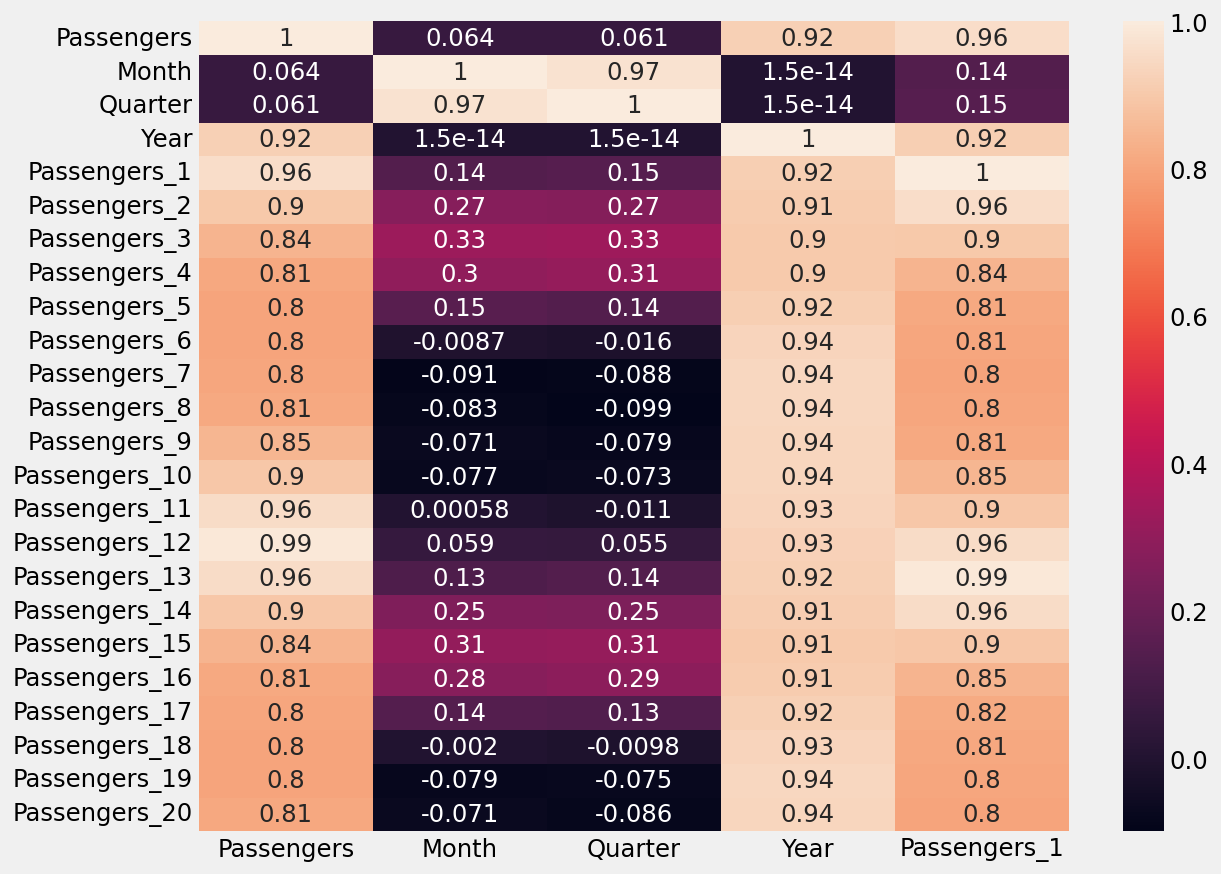

In [30]:
plt.figure(figsize=(10,8),dpi=125)
corr=dfv.corr()[:5].T
sns.heatmap(corr,annot=True)
plt.show()

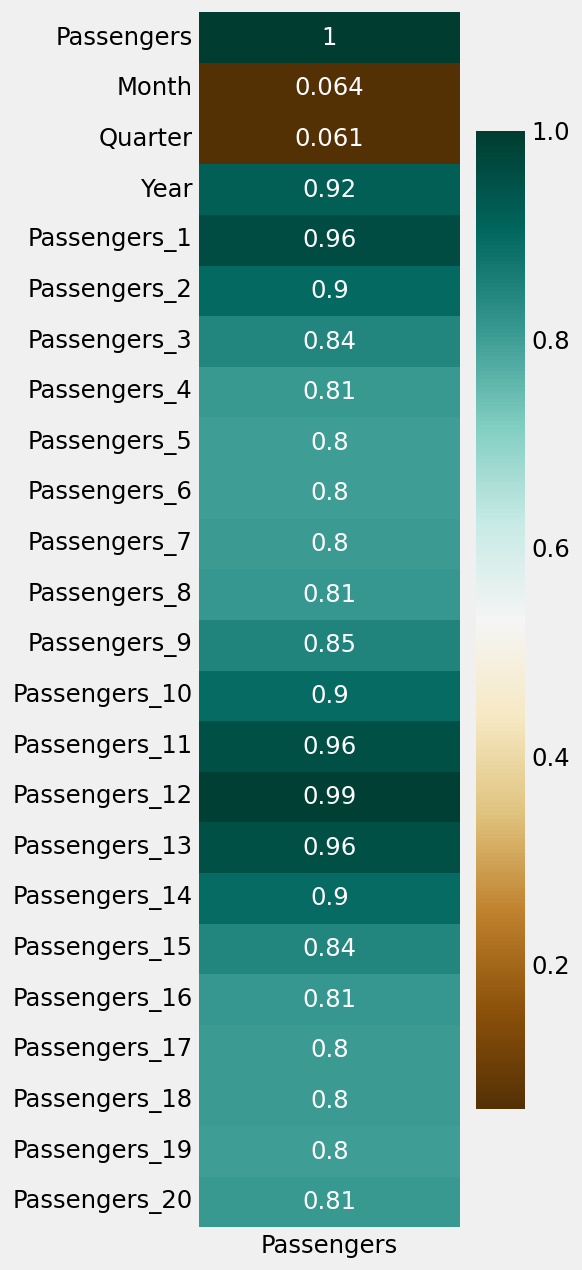

In [31]:
plt.figure(figsize=(3,12),dpi=125)
corr=dfv.corr()[:1].T
sns.heatmap(corr,cmap='BrBG',annot=True)
plt.show()

In [32]:
result = adfuller(dfv.iloc[:,:1])
dct={'ADF İstatistiği':result[0],
     'p-değer':result[1],
     'Gecikme Sayısı':result[2],
     'Gözelm Sayısı':result[3],
     }
dct.update(result[4])
result=pd.DataFrame([dct])
del dct
table=tabulate(result,headers="keys",
                     tablefmt='fancy_grid', floatfmt='.0f', showindex=False)
print(table)

╒═══════════════════╤═══════════╤══════════════════╤═════════════════╤══════╤══════╤═══════╕
│   ADF İstatistiği │   p-değer │   Gecikme Sayısı │   Gözelm Sayısı │   1% │   5% │   10% │
╞═══════════════════╪═══════════╪══════════════════╪═════════════════╪══════╪══════╪═══════╡
│                 1 │         1 │               13 │             130 │   -3 │   -3 │    -3 │
╘═══════════════════╧═══════════╧══════════════════╧═════════════════╧══════╧══════╧═══════╛


In [33]:
dfm=dfv.iloc[:,[0,1,2,3,4,5,6,14,15,16,17,18,23]]

In [34]:
dfm.shape

(144, 13)

3) Model Kurma

In [35]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [36]:
dfm.columns

Index(['Passengers', 'Month', 'Quarter', 'Year', 'Passengers_1',
       'Passengers_2', 'Passengers_3', 'Passengers_11', 'Passengers_12',
       'Passengers_13', 'Passengers_14', 'Passengers_15', 'Passengers_20'],
      dtype='object')

In [37]:
x_train=dfm.iloc[:100,1:]
y_train=dfm.iloc[:100,0:1]
x_test=dfm.iloc[100:,1:]
y_test=dfm.iloc[100:,0:1]

In [38]:
knn=KNeighborsRegressor()
xgb=XGBRegressor()
lgbm=LGBMRegressor(verbose=-1)
catb=CatBoostRegressor(verbose=0)
rf=RandomForestRegressor()
svr=SVR()

In [39]:
modeller = [knn,
            xgb,
            lgbm,
            rf,
            svr,
]


for model in modeller:
    isimler = model.__class__.__name__
    md = model.fit(x_train,y_train)
    y_pred = md.predict(x_test)
    rmse = mean_squared_error(y_test, y_pred,squared=True)
    print("-"*28)
    print(isimler + ":" )
    print("RMSE:{:.4f}".format(rmse))

----------------------------
KNeighborsRegressor:
RMSE:9493.0645
----------------------------
XGBRegressor:
RMSE:4930.5078
----------------------------
LGBMRegressor:
RMSE:12201.5254
----------------------------
RandomForestRegressor:
RMSE:5355.3620
----------------------------
SVR:
RMSE:51100.0039


3.1) Önem Verilen Değişkenler

In [40]:
model_tv1=lgbm.fit(x_train,y_train)

In [41]:
importances_df = pd.DataFrame({"feature_names" : model_tv1.feature_name_,
                               "importances" : model_tv1.feature_importances_})

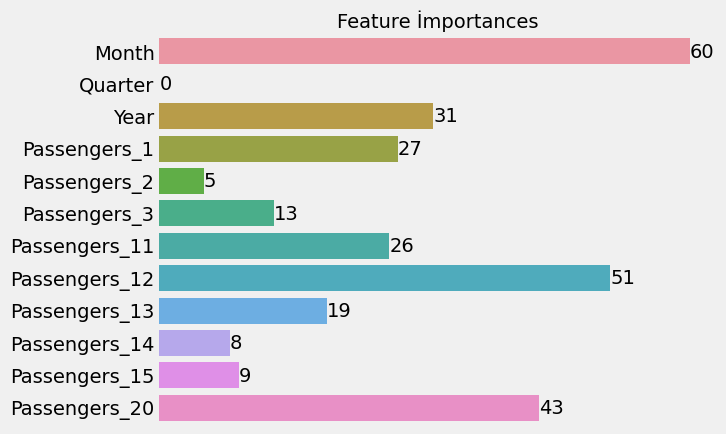

In [42]:
g = sns.barplot(data=importances_df,
                x="importances",
                y="feature_names")
sns.despine(bottom=True, left=True)
g.set_title("Feature İmportances", fontsize=14)
g.set(xticks=[])

# removing x and y axis labels by setting them to None
g.set(xlabel=None)
g.set(ylabel=None)
for value in g.containers:
    g.bar_label(value)

In [43]:
model_tv1=rf.fit(x_train,y_train)
importances_df = pd.DataFrame({"feature_names" : model_tv1.feature_names_in_,
                               "importances" : model_tv1.feature_importances_})
importances_df=np.round(importances_df,4)

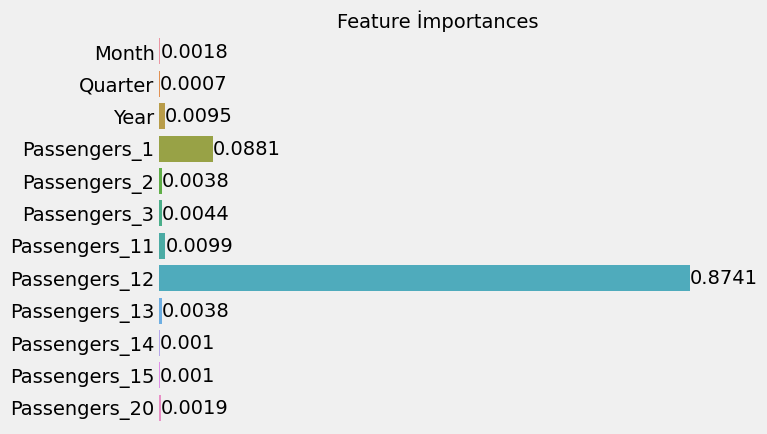

In [44]:
g = sns.barplot(data=importances_df,
                x="importances",
                y="feature_names")
sns.despine(bottom=True, left=True)
g.set_title("Feature İmportances", fontsize=14)
g.set(xticks=[])

# removing x and y axis labels by setting them to None
g.set(xlabel=None)
g.set(ylabel=None)
for value in g.containers:
    g.bar_label(value)

3.2) LGBM Denemesi

In [49]:
def objective(trial):
    param = {
        'metric': 'rmse',
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),

    }
    model = LGBMRegressor(**param,verbose=-1)

    model.fit(x_train,y_train,eval_set=[(x_test,y_test)])

    preds = model.predict(x_test)

    rmse = mean_squared_error(y_test, preds,squared=False)

    print(rmse)

    return rmse

In [53]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=68)

[I 2023-12-11 10:59:37,091] A new study created in memory with name: no-name-08ff58ae-dbc9-48ad-a286-2531ea4eaf53
[I 2023-12-11 10:59:37,879] Trial 0 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.03037550362093797, 'reg_lambda': 0.048494170275823825, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 810, 'min_child_samples': 185, 'min_data_per_groups': 24}. Best is trial 0 with value: 216.64411025710095.


216.64411025710095


[I 2023-12-11 10:59:38,751] Trial 1 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 2.50740550496492, 'reg_lambda': 0.03315924388963614, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 109, 'min_child_samples': 142, 'min_data_per_groups': 15}. Best is trial 0 with value: 216.64411025710095.


216.64411025710095


[I 2023-12-11 10:59:40,856] Trial 2 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 1.908338822581856, 'reg_lambda': 0.139139703037337, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 631, 'min_child_samples': 248, 'min_data_per_groups': 93}. Best is trial 0 with value: 216.64411025710095.


216.64411025710095


[I 2023-12-11 10:59:54,801] Trial 3 finished with value: 80.7551853879529 and parameters: {'reg_alpha': 0.1314487165831957, 'reg_lambda': 7.009692831420016, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 113, 'min_child_samples': 4, 'min_data_per_groups': 30}. Best is trial 3 with value: 80.7551853879529.


80.7551853879529


[I 2023-12-11 11:00:02,873] Trial 4 finished with value: 99.42626578692034 and parameters: {'reg_alpha': 0.004136469689425899, 'reg_lambda': 1.3430459737461142, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 119, 'min_child_samples': 17, 'min_data_per_groups': 46}. Best is trial 3 with value: 80.7551853879529.


99.42626578692034


[I 2023-12-11 11:00:03,532] Trial 5 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.0034521651188014015, 'reg_lambda': 1.9363068408075015, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 731, 'min_child_samples': 151, 'min_data_per_groups': 77}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:04,154] Trial 6 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.00814947489821857, 'reg_lambda': 7.638720785733494, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 81, 'min_child_samples': 97, 'min_data_per_groups': 52}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:04,707] Trial 7 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.013131091022766023, 'reg_lambda': 0.0051522327609167485, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 506, 'min_child_samples': 285, 'min_data_per_groups': 56}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:05,074] Trial 8 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 1.774325714868443, 'reg_lambda': 0.0012616934063130138, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 936, 'min_child_samples': 136, 'min_data_per_groups': 77}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:05,458] Trial 9 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 4.843094418881271, 'reg_lambda': 1.052574725383478, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 64, 'min_child_samples': 86, 'min_data_per_groups': 29}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:08,715] Trial 10 finished with value: 89.64556906228673 and parameters: {'reg_alpha': 0.2194448210047037, 'reg_lambda': 8.706421988971906, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 351, 'min_child_samples': 7, 'min_data_per_groups': 1}. Best is trial 3 with value: 80.7551853879529.


89.64556906228673


[I 2023-12-11 11:00:10,833] Trial 11 finished with value: 103.61386953146031 and parameters: {'reg_alpha': 0.1625536028218039, 'reg_lambda': 8.260107612463363, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 348, 'min_child_samples': 25, 'min_data_per_groups': 3}. Best is trial 3 with value: 80.7551853879529.


103.61386953146031


[I 2023-12-11 11:00:14,010] Trial 12 finished with value: 94.83126603017134 and parameters: {'reg_alpha': 0.23667085099916046, 'reg_lambda': 0.3456800672960683, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 324, 'min_child_samples': 9, 'min_data_per_groups': 5}. Best is trial 3 with value: 80.7551853879529.


94.83126603017134


[I 2023-12-11 11:00:14,400] Trial 13 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.5956297936999767, 'reg_lambda': 5.168595198129764, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 294, 'min_child_samples': 59, 'min_data_per_groups': 35}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:14,977] Trial 14 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.06580372194593259, 'reg_lambda': 0.42970598245938685, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 244, 'min_child_samples': 56, 'min_data_per_groups': 17}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:18,878] Trial 15 finished with value: 80.8189717253754 and parameters: {'reg_alpha': 0.4260267557256345, 'reg_lambda': 2.676432924162099, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 469, 'min_child_samples': 2, 'min_data_per_groups': 40}. Best is trial 3 with value: 80.7551853879529.


80.8189717253754


[I 2023-12-11 11:00:19,562] Trial 16 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.6232013147142405, 'reg_lambda': 2.173875393597799, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 521, 'min_child_samples': 56, 'min_data_per_groups': 40}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:20,324] Trial 17 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.06001962207884545, 'reg_lambda': 0.5745870416575448, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 195, 'min_child_samples': 210, 'min_data_per_groups': 62}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:21,304] Trial 18 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.4844837187130114, 'reg_lambda': 3.0872452026018236, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 448, 'min_child_samples': 100, 'min_data_per_groups': 66}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:26,058] Trial 19 finished with value: 132.2358623349132 and parameters: {'reg_alpha': 0.021684010334333495, 'reg_lambda': 0.14494171823996765, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 640, 'min_child_samples': 39, 'min_data_per_groups': 42}. Best is trial 3 with value: 80.7551853879529.


132.2358623349132


[I 2023-12-11 11:00:28,441] Trial 20 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 9.317571316468586, 'reg_lambda': 0.7952688301037963, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 930, 'min_child_samples': 79, 'min_data_per_groups': 21}. Best is trial 3 with value: 80.7551853879529.


216.64411025710095


[I 2023-12-11 11:00:30,929] Trial 21 finished with value: 82.94961983463513 and parameters: {'reg_alpha': 0.20859227647017792, 'reg_lambda': 4.171727160367011, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 405, 'min_child_samples': 2, 'min_data_per_groups': 11}. Best is trial 3 with value: 80.7551853879529.


82.94961983463513


[I 2023-12-11 11:00:32,688] Trial 22 finished with value: 80.30892669618437 and parameters: {'reg_alpha': 0.1082854933797923, 'reg_lambda': 4.410560060932984, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 6, 'min_child_samples': 1, 'min_data_per_groups': 29}. Best is trial 22 with value: 80.30892669618437.


80.30892669618437


[I 2023-12-11 11:00:35,188] Trial 23 finished with value: 138.20827765685075 and parameters: {'reg_alpha': 0.09701397582352836, 'reg_lambda': 2.803258067173499, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 30, 'min_child_samples': 42, 'min_data_per_groups': 33}. Best is trial 22 with value: 80.30892669618437.


138.20827765685075


[I 2023-12-11 11:00:38,092] Trial 24 finished with value: 113.4976451583287 and parameters: {'reg_alpha': 0.0010496208961860143, 'reg_lambda': 0.2639676823618924, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 195, 'min_child_samples': 32, 'min_data_per_groups': 29}. Best is trial 22 with value: 80.30892669618437.


113.4976451583287


[I 2023-12-11 11:00:40,987] Trial 25 finished with value: 87.26581345080002 and parameters: {'reg_alpha': 0.04122500590345961, 'reg_lambda': 0.013637788548090553, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 11, 'min_child_samples': 1, 'min_data_per_groups': 37}. Best is trial 22 with value: 80.30892669618437.


87.26581345080002


[I 2023-12-11 11:00:41,947] Trial 26 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.4944150814126823, 'reg_lambda': 1.3952232391384052, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 214, 'min_child_samples': 121, 'min_data_per_groups': 46}. Best is trial 22 with value: 80.30892669618437.


216.64411025710095


[I 2023-12-11 11:00:42,859] Trial 27 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.992454945926735, 'reg_lambda': 9.93999961284756, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 155, 'min_child_samples': 66, 'min_data_per_groups': 26}. Best is trial 22 with value: 80.30892669618437.


216.64411025710095


[I 2023-12-11 11:00:46,291] Trial 28 finished with value: 113.15112351521908 and parameters: {'reg_alpha': 0.11037172104482876, 'reg_lambda': 4.152508144380495, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 580, 'min_child_samples': 32, 'min_data_per_groups': 54}. Best is trial 22 with value: 80.30892669618437.


113.15112351521908


[I 2023-12-11 11:00:46,696] Trial 29 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.02875693102772728, 'reg_lambda': 0.05134128792751323, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 824, 'min_child_samples': 183, 'min_data_per_groups': 23}. Best is trial 22 with value: 80.30892669618437.


216.64411025710095


[I 2023-12-11 11:00:47,134] Trial 30 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.35761909408962966, 'reg_lambda': 0.7804829803861489, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 267, 'min_child_samples': 173, 'min_data_per_groups': 44}. Best is trial 22 with value: 80.30892669618437.


216.64411025710095


[I 2023-12-11 11:00:49,864] Trial 31 finished with value: 81.0012047474269 and parameters: {'reg_alpha': 0.13908575128371026, 'reg_lambda': 4.062727354925741, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 428, 'min_child_samples': 3, 'min_data_per_groups': 12}. Best is trial 22 with value: 80.30892669618437.


81.0012047474269


[I 2023-12-11 11:00:53,278] Trial 32 finished with value: 104.11951570836116 and parameters: {'reg_alpha': 0.10963809008253365, 'reg_lambda': 4.616624706339853, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 434, 'min_child_samples': 26, 'min_data_per_groups': 12}. Best is trial 22 with value: 80.30892669618437.


104.11951570836116


[I 2023-12-11 11:00:55,752] Trial 33 finished with value: 140.00578423674497 and parameters: {'reg_alpha': 0.9068387752859816, 'reg_lambda': 2.429440938711834, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 4, 'min_child_samples': 43, 'min_data_per_groups': 18}. Best is trial 22 with value: 80.30892669618437.


140.00578423674497


[I 2023-12-11 11:00:58,774] Trial 34 finished with value: 97.79803300046842 and parameters: {'reg_alpha': 0.3135986177492198, 'reg_lambda': 1.431228557176068, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 120, 'min_child_samples': 17, 'min_data_per_groups': 31}. Best is trial 22 with value: 80.30892669618437.


97.79803300046842


[I 2023-12-11 11:01:05,390] Trial 35 finished with value: 79.7454045768334 and parameters: {'reg_alpha': 0.050390950200536494, 'reg_lambda': 5.802149235464313, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 679, 'min_child_samples': 1, 'min_data_per_groups': 24}. Best is trial 35 with value: 79.7454045768334.


79.7454045768334


[I 2023-12-11 11:01:06,788] Trial 36 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.017471684594593324, 'reg_lambda': 6.154784621641926, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 724, 'min_child_samples': 237, 'min_data_per_groups': 23}. Best is trial 35 with value: 79.7454045768334.


216.64411025710095


[I 2023-12-11 11:01:09,401] Trial 37 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.04390878154428501, 'reg_lambda': 1.840782402987974, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 808, 'min_child_samples': 73, 'min_data_per_groups': 35}. Best is trial 35 with value: 79.7454045768334.


216.64411025710095


[I 2023-12-11 11:01:19,921] Trial 38 finished with value: 101.63480828867638 and parameters: {'reg_alpha': 0.012039963854255207, 'reg_lambda': 0.07215745715952472, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 683, 'min_child_samples': 22, 'min_data_per_groups': 38}. Best is trial 35 with value: 79.7454045768334.


101.63480828867638


[I 2023-12-11 11:01:24,492] Trial 39 finished with value: 144.6356993120989 and parameters: {'reg_alpha': 0.07547536464493947, 'reg_lambda': 0.1680622179903005, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 578, 'min_child_samples': 47, 'min_data_per_groups': 99}. Best is trial 35 with value: 79.7454045768334.


144.6356993120989


[I 2023-12-11 11:01:25,453] Trial 40 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.006574265910797514, 'reg_lambda': 0.013265739348165157, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 830, 'min_child_samples': 279, 'min_data_per_groups': 49}. Best is trial 35 with value: 79.7454045768334.


216.64411025710095


[I 2023-12-11 11:01:38,622] Trial 41 finished with value: 83.29092651176751 and parameters: {'reg_alpha': 0.15584502851233473, 'reg_lambda': 3.457054470490384, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 560, 'min_child_samples': 3, 'min_data_per_groups': 9}. Best is trial 35 with value: 79.7454045768334.


83.29092651176751


[I 2023-12-11 11:01:48,867] Trial 42 finished with value: 99.75893736595499 and parameters: {'reg_alpha': 0.0501256110724113, 'reg_lambda': 6.266061616342973, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 473, 'min_child_samples': 16, 'min_data_per_groups': 16}. Best is trial 35 with value: 79.7454045768334.


99.75893736595499


[I 2023-12-11 11:01:52,095] Trial 43 finished with value: 100.45539298193638 and parameters: {'reg_alpha': 0.13676636373298756, 'reg_lambda': 1.0469754561940214, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 384, 'min_child_samples': 18, 'min_data_per_groups': 27}. Best is trial 35 with value: 79.7454045768334.


100.45539298193638


[I 2023-12-11 11:01:55,403] Trial 44 finished with value: 84.74582491701237 and parameters: {'reg_alpha': 0.03023164532022897, 'reg_lambda': 6.317892899669714, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 72, 'min_child_samples': 1, 'min_data_per_groups': 21}. Best is trial 35 with value: 79.7454045768334.


84.74582491701237


[I 2023-12-11 11:01:55,848] Trial 45 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 1.7431462602694903, 'reg_lambda': 0.0012117887196163644, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 145, 'min_child_samples': 97, 'min_data_per_groups': 8}. Best is trial 35 with value: 79.7454045768334.


216.64411025710095


[I 2023-12-11 11:01:58,781] Trial 46 finished with value: 124.97951571804761 and parameters: {'reg_alpha': 0.3053721428596504, 'reg_lambda': 9.333204129795309, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 994, 'min_child_samples': 33, 'min_data_per_groups': 31}. Best is trial 35 with value: 79.7454045768334.


124.97951571804761


[I 2023-12-11 11:02:03,034] Trial 47 finished with value: 101.44912814097324 and parameters: {'reg_alpha': 0.07796268885306588, 'reg_lambda': 2.19491452936958, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 633, 'min_child_samples': 15, 'min_data_per_groups': 14}. Best is trial 35 with value: 79.7454045768334.


101.44912814097324


[I 2023-12-11 11:02:03,745] Trial 48 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.18691174846475225, 'reg_lambda': 3.456386331884028, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 527, 'min_child_samples': 122, 'min_data_per_groups': 58}. Best is trial 35 with value: 79.7454045768334.


216.64411025710095


[I 2023-12-11 11:02:04,466] Trial 49 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.9762551558767281, 'reg_lambda': 1.648706500733344, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 312, 'min_child_samples': 53, 'min_data_per_groups': 49}. Best is trial 35 with value: 79.7454045768334.


216.64411025710095


[I 2023-12-11 11:02:07,849] Trial 50 finished with value: 106.58047507087817 and parameters: {'reg_alpha': 0.25879458576531345, 'reg_lambda': 0.0024568700613675928, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 759, 'min_child_samples': 27, 'min_data_per_groups': 79}. Best is trial 35 with value: 79.7454045768334.


106.58047507087817


[I 2023-12-11 11:02:10,118] Trial 51 finished with value: 87.41670860984058 and parameters: {'reg_alpha': 0.1957007881678697, 'reg_lambda': 4.6864134168202645, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 425, 'min_child_samples': 1, 'min_data_per_groups': 11}. Best is trial 35 with value: 79.7454045768334.


87.41670860984058


[I 2023-12-11 11:02:13,581] Trial 52 finished with value: 97.54528532780327 and parameters: {'reg_alpha': 0.1261464941585682, 'reg_lambda': 5.936650269071781, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 385, 'min_child_samples': 11, 'min_data_per_groups': 18}. Best is trial 35 with value: 79.7454045768334.


97.54528532780327


[I 2023-12-11 11:02:16,996] Trial 53 finished with value: 100.16350424253233 and parameters: {'reg_alpha': 0.4451613412416078, 'reg_lambda': 2.988588429493199, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 372, 'min_child_samples': 12, 'min_data_per_groups': 5}. Best is trial 35 with value: 79.7454045768334.


100.16350424253233


[I 2023-12-11 11:02:19,970] Trial 54 finished with value: 130.0453541836416 and parameters: {'reg_alpha': 0.0852033115456498, 'reg_lambda': 1.014192395235784, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 508, 'min_child_samples': 38, 'min_data_per_groups': 24}. Best is trial 35 with value: 79.7454045768334.


130.0453541836416


[I 2023-12-11 11:02:23,039] Trial 55 finished with value: 106.68771953071389 and parameters: {'reg_alpha': 0.22340107692029765, 'reg_lambda': 4.2430962837720765, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 37, 'min_child_samples': 25, 'min_data_per_groups': 20}. Best is trial 35 with value: 79.7454045768334.


106.68771953071389


[I 2023-12-11 11:02:23,782] Trial 56 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.05562416970192351, 'reg_lambda': 7.721106809517406, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 101, 'min_child_samples': 64, 'min_data_per_groups': 41}. Best is trial 35 with value: 79.7454045768334.


216.64411025710095


[I 2023-12-11 11:02:25,666] Trial 57 finished with value: 157.59246149015925 and parameters: {'reg_alpha': 3.149674500147446, 'reg_lambda': 0.5651916164482731, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 455, 'min_child_samples': 50, 'min_data_per_groups': 6}. Best is trial 35 with value: 79.7454045768334.


157.59246149015925


[I 2023-12-11 11:02:29,158] Trial 58 finished with value: 97.22621311973478 and parameters: {'reg_alpha': 0.03704202480055812, 'reg_lambda': 2.830162845839275, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 410, 'min_child_samples': 11, 'min_data_per_groups': 1}. Best is trial 35 with value: 79.7454045768334.


97.22621311973478


[I 2023-12-11 11:02:31,684] Trial 59 finished with value: 94.30180902760816 and parameters: {'reg_alpha': 0.6731948409465142, 'reg_lambda': 9.622204316743753, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 480, 'min_child_samples': 1, 'min_data_per_groups': 14}. Best is trial 35 with value: 79.7454045768334.


94.30180902760816


[I 2023-12-11 11:02:32,096] Trial 60 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.1631873861795241, 'reg_lambda': 1.8568096068138422, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 283, 'min_child_samples': 158, 'min_data_per_groups': 28}. Best is trial 35 with value: 79.7454045768334.


216.64411025710095


[I 2023-12-11 11:02:33,978] Trial 61 finished with value: 91.3964187740887 and parameters: {'reg_alpha': 0.406676518786673, 'reg_lambda': 4.142486820653447, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 594, 'min_child_samples': 1, 'min_data_per_groups': 9}. Best is trial 35 with value: 79.7454045768334.


91.3964187740887


[I 2023-12-11 11:02:37,734] Trial 62 finished with value: 103.62381935415728 and parameters: {'reg_alpha': 0.15204641635350638, 'reg_lambda': 3.5485479643031232, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 527, 'min_child_samples': 22, 'min_data_per_groups': 34}. Best is trial 35 with value: 79.7454045768334.


103.62381935415728


[I 2023-12-11 11:02:40,815] Trial 63 finished with value: 127.56337711418766 and parameters: {'reg_alpha': 0.10142997456747926, 'reg_lambda': 6.366751316201002, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 579, 'min_child_samples': 36, 'min_data_per_groups': 12}. Best is trial 35 with value: 79.7454045768334.


127.56337711418766


[I 2023-12-11 11:02:44,103] Trial 64 finished with value: 94.10192589315164 and parameters: {'reg_alpha': 0.2666532982748462, 'reg_lambda': 2.2704044100763663, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 672, 'min_child_samples': 9, 'min_data_per_groups': 9}. Best is trial 35 with value: 79.7454045768334.


94.10192589315164


[I 2023-12-11 11:02:46,114] Trial 65 finished with value: 106.46109890891262 and parameters: {'reg_alpha': 0.05799141524197615, 'reg_lambda': 5.046747508116646, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 244, 'min_child_samples': 28, 'min_data_per_groups': 25}. Best is trial 35 with value: 79.7454045768334.


106.46109890891262


[I 2023-12-11 11:02:46,537] Trial 66 finished with value: 216.64411025710095 and parameters: {'reg_alpha': 0.665164966613004, 'reg_lambda': 3.4249847535017195, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 330, 'min_child_samples': 216, 'min_data_per_groups': 32}. Best is trial 35 with value: 79.7454045768334.


216.64411025710095


[I 2023-12-11 11:02:50,361] Trial 67 finished with value: 85.11305551579794 and parameters: {'reg_alpha': 0.02433284555336142, 'reg_lambda': 1.3179081047764005, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 554, 'min_child_samples': 8, 'min_data_per_groups': 38}. Best is trial 35 with value: 79.7454045768334.


85.11305551579794


In [58]:
optimised_lgbm=LGBMRegressor(**study.best_params,verbose=-1)

optimised_lgbm.fit(x_train ,y_train,eval_set=[(x_test,y_test)])
y_pred = optimised_lgbm.predict(x_test)
rmse = mean_squared_error(y_test, y_pred,squared=False)

In [59]:
rmse

144.98473073991346

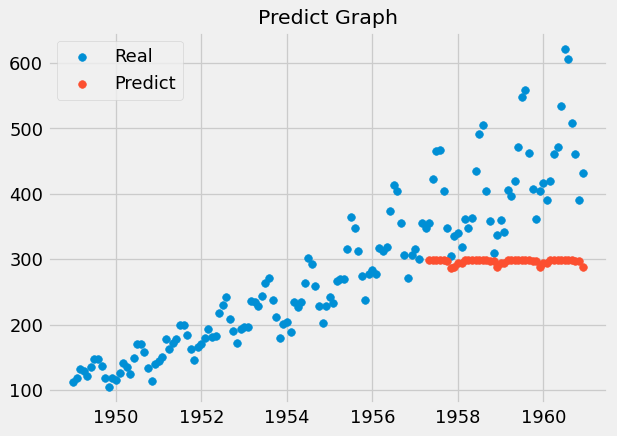

In [60]:
plt.figure(figsize=(7,5),dpi=92)
plt.title('Predict Graph',fontsize=16)
plt.scatter(df.Month,df.Passengers,label='Real')
plt.scatter(df.iloc[100:,0],y_pred,label='Predict')
plt.legend()
plt.show()

3.3) SVR Denemsesi

In [61]:

def objective(trial):
    # Hiperparametrelerin aralığını belirleyelim
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    epsilon = trial.suggest_uniform('epsilon', 0.001, 0.1)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])

    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
        coef0 = trial.suggest_uniform('coef0', 0.0, 1.0)
        model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree, coef0=coef0)
    else:
        gamma = trial.suggest_loguniform('gamma', 0.001, 1.0)
        model = SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)

    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
        coef0 = trial.suggest_uniform('coef0', 0.0, 1.0)
    else:
        degree = 3
        coef0 = 0.0

    if kernel == 'rbf':
        gamma = trial.suggest_loguniform('gamma', 1e-5, 1e2)
    else:
        gamma = 'scale'

    # Modeli eğitelim
    model.fit(x_train, y_train)

    # Modelin performansını değerlendirelim
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse


In [ ]:

# Optuna optimizasyon döngüsünü çalıştıralım
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)





In [ ]:
best_params = study.best_params
print("En iyi hiperparametreler:", best_params)

# En iyi modeli eğitelim
best_model = SVR(**best_params)
best_model.fit(x_train, y_train)

En iyi hiperparametreler: {'C': 0.01038030863363632, 'epsilon': 0.004272782367727957, 'kernel': 'linear', 'gamma': 0.1084890515851734}


SVR(C=0.01038030863363632, epsilon=0.004272782367727957,
    gamma=0.1084890515851734, kernel='linear')

In [ ]:
y_pred=best_model.predict(x_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred,squared=False)
mse

13.66007379751879

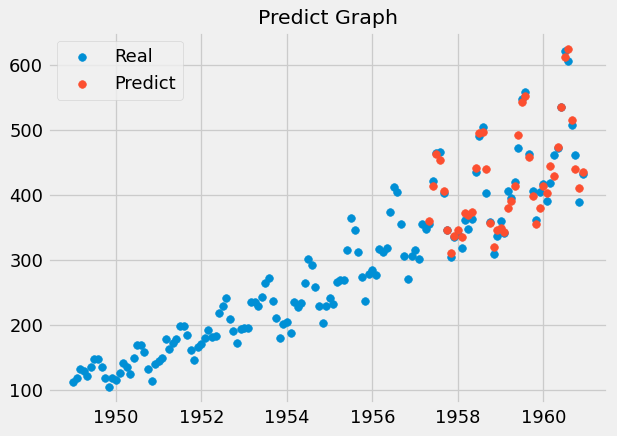

In [ ]:
plt.figure(figsize=(7,5),dpi=92)
plt.title('Predict Graph',fontsize=16)
plt.scatter(df.Month,df.Passengers,label='Real')
plt.scatter(df.iloc[100:,0],y_pred,label='Predict')
plt.legend()
plt.show()

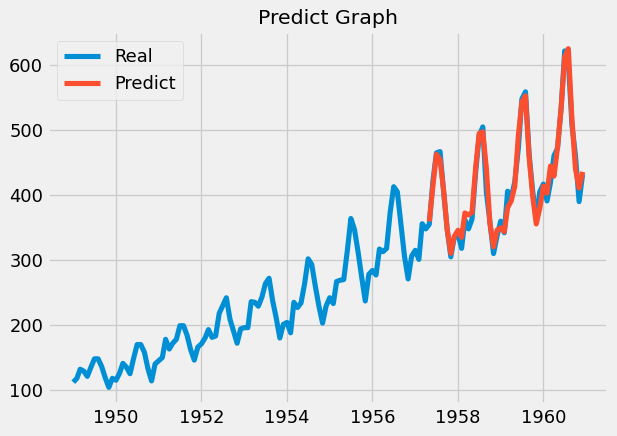

In [ ]:
plt.figure(figsize=(7,5),dpi=92)
plt.title('Predict Graph',fontsize=16)
plt.plot(df.Month,df.Passengers,label='Real')
plt.plot(df.iloc[100:,0],y_pred,label='Predict')
plt.legend()
plt.show()

In [ ]:
importances_df = pd.DataFrame({"feature_names" : x_train.columns.to_list(),
                               "importances" : np.abs(best_model.coef_).ravel().tolist()})
importances_df=np.round(importances_df,4)

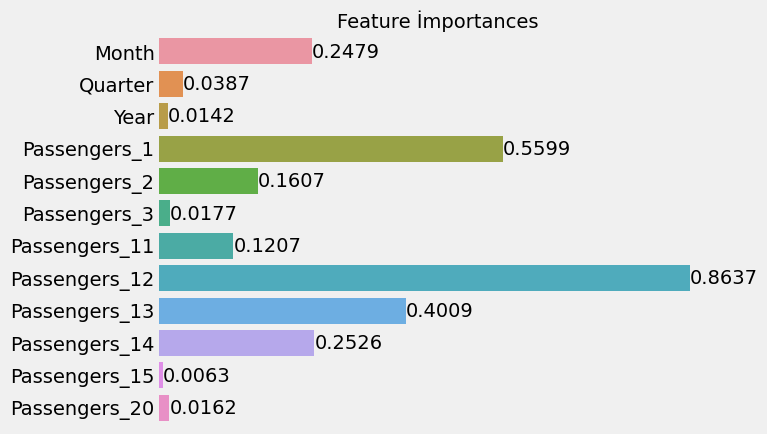

In [ ]:
g = sns.barplot(data=importances_df,
                x="importances",
                y="feature_names")
sns.despine(bottom=True, left=True)
g.set_title("Feature İmportances", fontsize=14)
g.set(xticks=[])

# removing x and y axis labels by setting them to None
g.set(xlabel=None)
g.set(ylabel=None)
for value in g.containers:
    g.bar_label(value)

3.4) Zaman Serisi Modelleri


In [ ]:
dfz=df.set_index('Month')
train=dfz.iloc[:100,:]
test=dfz.iloc[100:,:]


3.4.1) Hold Winters

In [ ]:
def objective(trial):
    trend_type = trial.suggest_categorical('trend_type', ['add', 'mul','additive','multiplicative'])
    seasonal_type = trial.suggest_categorical('seasonal_type', ['add', 'mul','additive','multiplicative'])
    seasonal_periods = trial.suggest_int('seasonal_periods', 2, 10)

    model = ExponentialSmoothing(train, trend=trend_type, seasonal=seasonal_type, seasonal_periods=seasonal_periods)
    model = model.fit()

    forecast = model.predict(start='1957-05-01', end='-1960-12-01	')


    error = ((test.values - forecast.values) ** 2).mean()
    return error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_error = study.best_value

In [ ]:
best_params

{'trend_type': 'additive',
 'seasonal_type': 'multiplicative',
 'seasonal_periods': 5}

In [ ]:
hw=ExponentialSmoothing(train,trend='add',seasonal='multiplicative',seasonal_periods=5)
hw=hw.fit()
forecast = hw.predict(start='1957-05-01', end='1960-12-01')

In [ ]:

error = ((test.values - forecast.values) ** 2).mean()
np.sqrt(error)

83.85935432567837

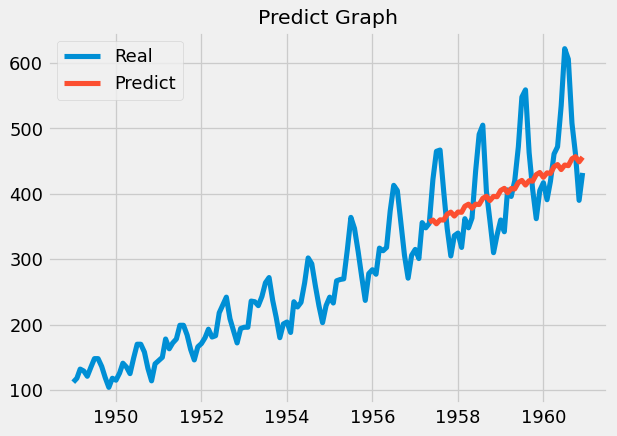

In [ ]:
plt.figure(figsize=(7,5),dpi=92)
plt.title('Predict Graph',fontsize=16)
plt.plot(df.Month,df.Passengers,label='Real')
plt.plot(df.iloc[100:,0],forecast.values,label='Predict')
plt.legend()
plt.show()

3.4.2) ETS Model

In [ ]:
def objective(trial):
    trend = trial.suggest_categorical('trend', ['add', 'mul','additive','multiplicative'])
    seasonal = trial.suggest_categorical('seasonal', ['add', 'mul','additive','multiplicative'])
    error = trial.suggest_categorical("error",['add', 'mul','additive','multiplicative'])
    seasonal_periods = trial.suggest_int('seasonal_periods', 2, 12)

    model = ETSModel(train.Passengers, error=error, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model = model.fit()
    forecast = model.forecast(steps=44)



    error = np.sqrt(((forecast.values - test.values) ** 2).mean())
    return error
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=432)

best_params = study.best_params
best_error = study.best_value

optuna.visualization.plot_optimization_history(study)
plt.show()

In [ ]:
model=ETSModel(train.Passengers,**best_params)
model=model.fit()
forcast=model.forecast(steps=44)

In [ ]:
error = np.sqrt(((forcast.values - test.values) ** 2).mean())
error

83.8654100596111

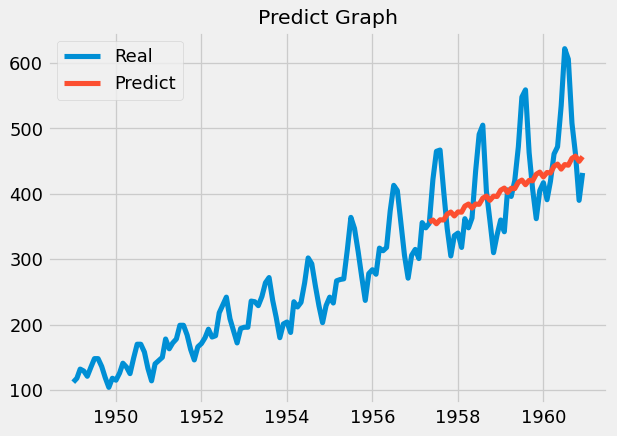

In [ ]:
plt.figure(figsize=(7,5),dpi=92)
plt.title('Predict Graph',fontsize=16)
plt.plot(df.Month,df.Passengers,label='Real')
plt.plot(df.iloc[100:,0],forcast.values,label='Predict')
plt.legend()
plt.show()

3.4.3) Arimna Modeli

In [ ]:

def objective(trial):
    p = trial.suggest_int('p', 1, 15)
    d = trial.suggest_int('d', 1, 3)
    q = trial.suggest_int('q', 1, 15)



    model = ARIMA(train.Passengers, order=(p, d, q))
    model=model.fit()
    forecast = model.forecast(steps=44)

    error = np.sqrt(((forecast.values - test.values) ** 2).mean())
    return error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250, n_jobs=-1)

best_params = study.best_params
best_error = study.best_value


In [ ]:
best_params

{'p': 10, 'd': 3, 'q': 12}

In [ ]:
error = np.sqrt(((forcast.values - test.values) ** 2).mean())
error

82.77644109985695

In [ ]:
model=ARIMA(train.Passengers,order=(best_params['p'],best_params['d'],best_params['q']))
model=model.fit()
forcast=model.forecast(steps=44)

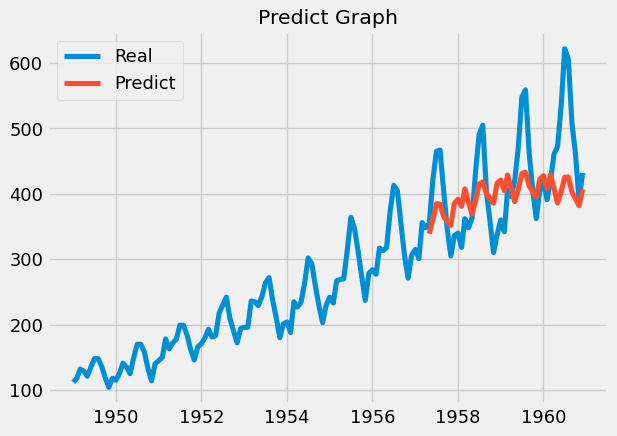

In [ ]:
plt.figure(figsize=(7,5),dpi=92)
plt.title('Predict Graph',fontsize=16)
plt.plot(df.Month,df.Passengers,label='Real')
plt.plot(df.iloc[100:,0],forcast.values,label='Predict')
plt.legend()
plt.show()

In [ ]:
df_train=dfv.iloc[:100,:1]
exogenous=dfv.iloc[:100,1:]
exogenous_p=dfv.iloc[100,1:]
df_test=dfv.iloc[100:,:1]

In [ ]:
model=pm.auto_arima(df_train,exogenus=exogenous,trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train,exogenus=exogenous)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=909.769, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=907.370, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=904.979, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=908.785, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=900.136, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=904.858, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=898.911, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=903.548, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=906.025, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=896.369, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=903.746, Time=0.06 se

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
forecast = model.predict(n_periods=44, exogenous=exogenous_p)

In [ ]:
error = np.sqrt(((forecast.values - test.values) ** 2).mean())
error

122.05110886750873

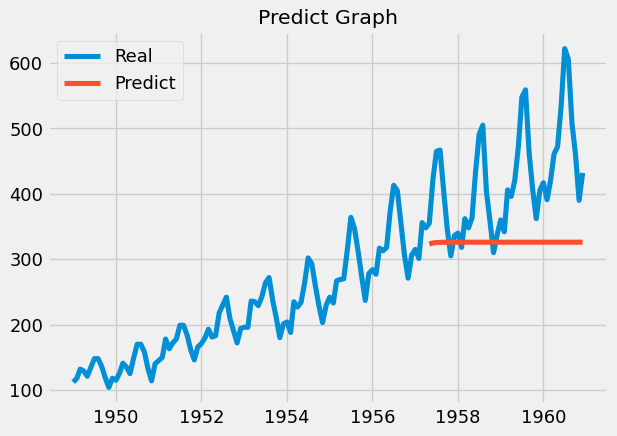

In [ ]:
plt.figure(figsize=(7,5),dpi=92)
plt.title('Predict Graph',fontsize=16)
plt.plot(df.Month,df.Passengers,label='Real')
plt.plot(df.iloc[100:,0],forecast.values,label='Predict')
plt.legend()
plt.show()

In [ ]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X),np.array(Y)

In [ ]:
x_train,y_train=create_features(tr,16)
x_test,y_test=create_features(ts,16)

In [ ]:
x_train=np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test=np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [ ]:
model=Sequential()
model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(x_train.shape[1],16)))
model.add(Dropout(0,2))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                3350      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train.shape

(84, 1, 16)

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
callbacks=[EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min'),
          ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
                          save_best_only=True,save_weighs_only=False,verbose=1)]

In [ ]:
history=model.fit(x_train,y_train,epochs=150,batch_size=1,validation_data=(x_test,y_test),callbacks=callbacks,shuffle=False)

Epoch 1/150
82/84 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 1: val_loss improved from inf to 0.01320, saving model to mymodel.h5
84/84 [==============================] - 2s 7ms/step - loss: 0.0058 - val_loss: 0.0132
Epoch 2/150
77/84 [==========================>...] - ETA: 0s - loss: 0.0032
Epoch 2: val_loss improved from 0.01320 to 0.00956, saving model to mymodel.h5
84/84 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0096
Epoch 3/150
75/84 [=========================>....] - ETA: 0s - loss: 0.0027
Epoch 3: val_loss improved from 0.00956 to 0.00801, saving model to mymodel.h5
84/84 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 0.0080
Epoch 4/150
80/84 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 4: val_loss improved from 0.00801 to 0.00689, saving model to mymodel.h5
84/84 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0069
Epoch 5/150
77/84 [=================

In [ ]:
loss=model.evaluate(x_test,y_test,batch_size=15)
print("\nTest loss: %.1f%%"%(100.0*loss))

2/2 [==============================] - 1s 7ms/step - loss: 0.0046

Test loss: 0.5%


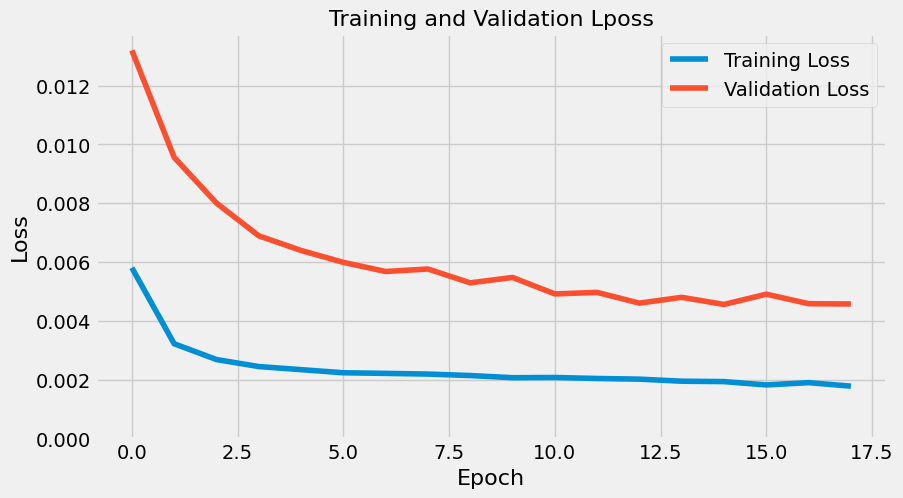

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Lposs',fontsize=16)
plt.show()

In [ ]:
train_p=model.predict(x_train)
test_p=model.predict(x_test)

1/1 [==============================] - 0s 42ms/step


In [ ]:
train_p=sc_tr.inverse_transform(train_p)
test_p=sc_ts.inverse_transform(test_p)

In [ ]:
y_train=sc_tr.inverse_transform(y_train)
y_test=sc_ts.inverse_transform(y_test)

In [ ]:
train_rmse=mean_squared_error(y_train,train_p,squared=False)
test_rmse=mean_squared_error(y_test,test_p,squared=False)

In [ ]:
train_rmse

14.135434

In [ ]:
test_rmse

21.44006

In [ ]:
result_df=df.copy()
result_df=result_df.set_index('Month')
result_tr=result_df[16:100]
result_tr['Predicted']=train_p

result_ts=result_df[116:144]
result_ts['Predicted']=test_p


In [ ]:
result_ts.tail()

,Passengers,Predicted
Month,,
1960-08-01,606.0,599.834167
1960-09-01,508.0,512.845703
1960-10-01,461.0,426.404419
1960-11-01,390.0,401.624847
1960-12-01,432.0,423.752747


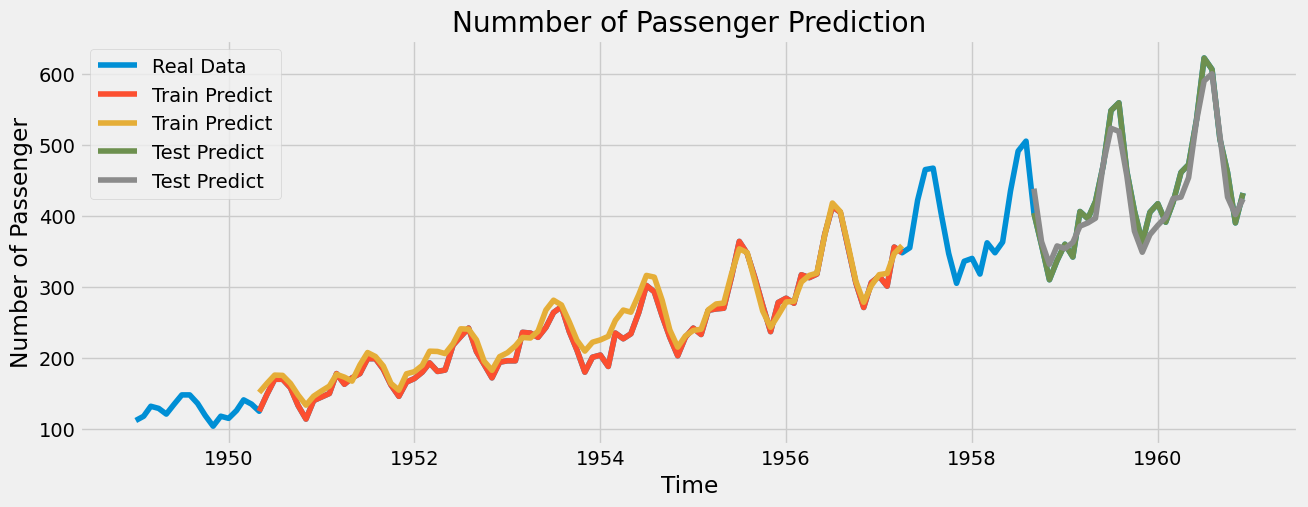

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label='Real Data')
plt.plot(result_tr,label='Train Predict')
plt.plot(result_ts,label='Test Predict')
plt.title('Nummber of Passenger Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passenger')
plt.legend()
plt.show()